# What Molecule matches Shohei Ohtani's 2024 Season?!

Let's use `diamondfp` to create a fingeprint of Shohei Ohtani's incredible 2024 season and compare it to molecules in the [ChEMBL](https://www.ebi.ac.uk/chembl/) chemical database!

Steps:
- Install [RDKit](https://www.rdkit.org/) for the chemistry bits later
- Get your [Baseball Savant](https://baseballsavant.mlb.com/) data for the 2024 season
- Generate your feature quantiles and the fingerprint representation for Shohei Ohtani
- Create fingerprints for ChEMBL molecules
- Run a similarity search and determine which molecule closest matches Shohei Ohtaini

For the full write up, please checkout [my website](https://dlf57.github.io/projects/molbaseball/). 

In [ ]:
import pandas as pd
from diamondfp.fingerprints import binaryfp
from diamondfp.utils.features import generate_quantiles
from diamondfp.scoring import tanimoto
# RDKit imports for handling molecules
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## diamondfp Processing Workflow

From Baseball Savant the desired fingerprint stats were preselected. Once read in to Python, the feature quantiles were generated. The number of stats and quantiles were selected to make a 256 bit vector to best compare to molecules. (Traditionally 2048 is the molecular fingerprint size of choice but for this activity we are going to shrink to 256)

In [ ]:
# read in 2024 player data
df = pd.read_csv("../data/2024fp_256bit.csv")

# create name column from last_name, first_name
def make_name(row):
    last_name, first_name = row["last_name, first_name"].split(", ")
    return f"{first_name} {last_name}"

df['name'] = df.apply(lambda x: make_name(x), axis=1)

# generate quantiles for stats
stat_list = list(df.columns)[3:-1]
quant_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.99]
stat_features = {stat: quant_list for stat in stat_list}
feat_quants = generate_quantiles(df, stat_features)

# generate fingerprint for Shohei Ohtani
shohei_ohtani = binaryfp(df[df["name"] == "Shohei Ohtani"].squeeze(), feat_quants)

## Processing Molecules

ChEMBL stores the roughly 2.5 million SMILES strings in a tab separated file. We will read these in and use the RDKitFP generator to create a 256 bit vector fingerprint of the molecules. Other fingerprints like Morgan Fingerprints could also be used. 

I recommend lowering the path length and only using a subset of the ChEMBL dataset as this will take a very long time.

In [ ]:
df_chem = pd.read_csv("../data/chembl_35_chemreps.txt", sep="\t")

fps = []
for i in range(len(df_chem)):
    try:
        smiles = df_chem['canonical_smiles'].iloc[i]
        chembl_id = df_chem['chembl_id'].iloc[i]
        mol = Chem.MolFromSmiles(smiles)
        rdfgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=256)
        fp = rdfgen.GetFingerprint(mol)
        d = {}
        d.update({'ChEMBL ID': chembl_id})
        d.update({'SMILES': smiles})
        d.update({'fingerprint': fp})
        fps.append(d)
    except:
        pass


## Scoring

Now that we have all of the fingerprints from ChEMBL made, we can compare them to Shohei Ohtani to generate a Tanimoto Score. We can then sort by the dataframe by score and see which molecule has the fingerprint closest to Shohei Ohtani's 2024 season.

In [4]:
results = []

for i in range(len(fps)):
    chembl_id = fps[i]['ChEMBL ID']
    score = tanimoto(shohei_ohtani, fps[i]['fingerprint'])
    d = {}
    d.update({'ChEMBL ID': chembl_id})
    d.update({'SMILES': fps[i]['SMILES']})
    d.update({'Score': score})
    results.append(d)

In [5]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='Score', ascending=False)
df_results.head(10)

,ChEMBL ID,SMILES,Score
1270559,CHEMBL5489980,CN(C)c1ccc(NC(=O)CCc2nc(Cc3ccccc3)no2)cn1,0.798387
572227,CHEMBL543342,Cl.O=C(O)C1=CCCN(CCOCCN2c3ccccc3CCc3ccccc32)C1,0.795181
2296225,CHEMBL3923723,COCCC(=O)N1[C@H](C)CNc2ccccc2[C@@H]1C,0.795181
852252,CHEMBL1192156,O=C(O)C1=CCCN(CCOCCN2c3ccccc3CCc3ccccc32)C1,0.795181
2052737,CHEMBL3458430,O=C(CS(=O)(=O)Cc1nnnn1C1CC1)NCCc1ccccc1,0.793522
923889,CHEMBL397829,O=C(O)C(O)(Cc1cccnc1)P(=O)(O)O,0.792683
1191146,CHEMBL1395909,CCOc1ncccc1C(=O)OCC(=O)Nc1ccc2c(c1)CCC2,0.792000
2060991,CHEMBL3477461,CCC(=O)N1CCN(C(=O)Nc2cccc(F)c2)[C@H]2CS(=O)(=O...,0.792000
1731411,CHEMBL2005900,CCc1cccc(C)c1NC(=O)C(=O)CC(=O)c1ccc(Cl)s1,0.792000
712471,CHEMBL4754559,COC[C@H](NC(=O)[C@H](CC(=O)NOC(C)(C)C)NC(=O)CC...,0.792000


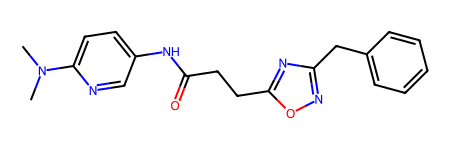

In [6]:
mol = Chem.MolFromSmiles(df_results['SMILES'].iloc[0])
mol

In [9]:
!pip install py3Dmol

In [15]:
import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(mol),'sdf')
view.setStyle({'stick':{}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Final Thoughts

This was a really fun experiment for me to do. While finding the molecule that matches Shohei Ohtani has no real meaning, it shows off fingerprints and similarity scoring in a fun way. It was also a great way to link two of my favorite things, chemistry and baseball, in a way that I had never really thought of prior to `diamondfp`.